<a href="https://colab.research.google.com/github/ravindrabharathi/AVS-provisioning-Java/blob/master/007_PersonAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
project_folder="/content/gdrive/My Drive/EIP4/session5"

!rm -R ./resized
!rm hvc_annotations.csv
!unzip -q "/content/gdrive/My Drive/EIP4/session5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
rm: cannot remove './resized': No such file or directory
rm: cannot remove 'hvc_annotations.csv': No such file or directory
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input,Conv2D,GlobalAveragePooling2D,BatchNormalization,MaxPooling2D,Activation,Lambda,GlobalMaxPooling2D,Add
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
!rm -Rf './resized'

In [0]:
!tar -xf '/content/gdrive/My Drive/EIP4/session5/cropped.tar' 

In [0]:
def resize_img(img,dim):
  return cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)

In [0]:
import os
image_list2=os.listdir('./cropped/')
!rm -Rf './resized'
!mkdir './resized'
print('starting to resize to 112x224 ...')
for i in range(len(image_list2)):
  image=cv2.imread('./cropped/'+image_list2[i])
  image1=resize_img(image,(112,224))
  #cv2_imshow(image1)
  cv2.imwrite('./resized/'+image_list2[i],image1)
  if (i%1000==0):
    print('processed ',i,'images')

starting to resize to 112x224 ...
processed  0 images
processed  1000 images
processed  2000 images
processed  3000 images
processed  4000 images
processed  5000 images
processed  6000 images
processed  7000 images
processed  8000 images
processed  9000 images
processed  10000 images
processed  11000 images
processed  12000 images
processed  13000 images


In [0]:
print(len(os.listdir('./cropped/')),len(os.listdir('./resized/')))

13573 13573


In [0]:

image_data=[]
for i in range(len(image_list2)):
  img=cv2.imread('./resized/'+image_list2[i])
  
  image_data.append(img)
image_data=np.array(image_data) 
print(image_data.shape)
images_mean=np.mean(image_data,axis=(0,1,2))
images_std=np.std(image_data,axis=(0,1,2))
print(images_mean,images_std)


(13573, 224, 112, 3)
[ 95.55573314  96.53671704 107.34702047] [64.81507208 65.94565732 67.6457798 ]


In [0]:
images_mean=[ 95.55573314,  96.53671704, 107.34702047]
images_std= [64.81507208, 65.94565732, 67.6457798 ]

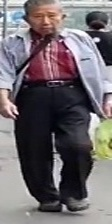

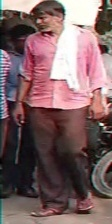

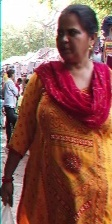

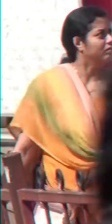

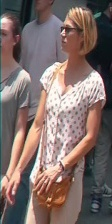

In [0]:
for i in range(5):
  img=cv2.imread('./resized/'+image_list2[i])
  cv2_imshow(img)
  print('\n\n')


In [0]:
def crop_top(img):
  shp=img.shape
  #print('shape',shp)
  h1=img.shape[1]//2
  
  return img[:,0:h1,:,:]

In [0]:
def crop_botm(img):
  shp=img.shape
  #print('shape',shp)
  h1=img.shape[1]//2
  
  return img[:,h1:,:,:]

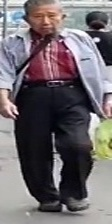

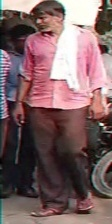

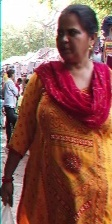

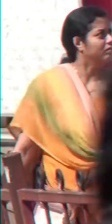

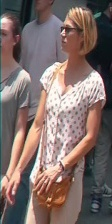




............


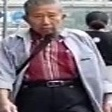

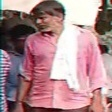

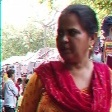

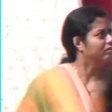

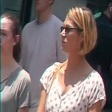

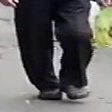

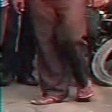

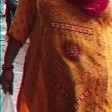

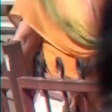

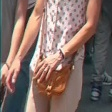

In [0]:
batch1=[]
for i in range(5):
  img=cv2.imread('./resized/'+image_list2[i])
  cv2_imshow(img)
  print("\n\n")
  batch1.append(img)
batch1=np.array(batch1)  
print('............')     
#print(batch1.shape)

batch2=crop_top(batch1)
#print(batch2.shape)

for img in batch2:
  cv2_imshow(img)
  print("\n\n")

batch2=crop_botm(batch1)
#print(batch2.shape)

for img in batch2:
  cv2_imshow(img)
  print("\n\n")



In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

gender imagequality    age  ...        emotion        bodypose     image_path
0    male      Average  35-45  ...        Neutral  Front-Frontish  resized/1.jpg
1  female      Average  35-45  ...  Angry/Serious  Front-Frontish  resized/2.jpg
2    male         Good  45-55  ...        Neutral  Front-Frontish  resized/3.jpg
3    male         Good  45-55  ...        Neutral  Front-Frontish  resized/4.jpg
4  female         Good  35-45  ...        Neutral  Front-Frontish  resized/5.jpg

[5 rows x 9 columns]

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13573 entries, 0 to 13572
Data columns (total 9 columns):
gender          13573 non-null object
imagequality    13573 non-null object
age             13573 non-null object
weight          13573 non-null object
carryingbag     13573 non-null object
footwear        13573 non-null object
emotion         13573 non-null object
bodypose        13573 non-null object
image_path      13573 non-null object
dtypes: object(9)
memory usage: 954.5+ KB




      --------    gender      --------


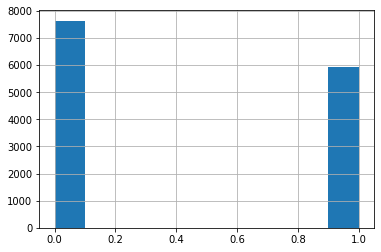



      --------    imagequality      --------


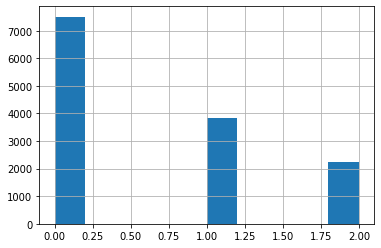



      --------    age      --------


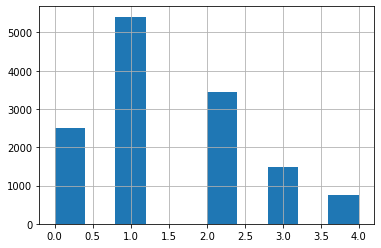



      --------    weight      --------


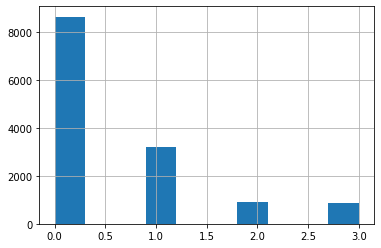



      --------    carryingbag      --------


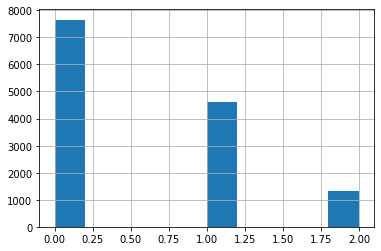



      --------    footwear      --------


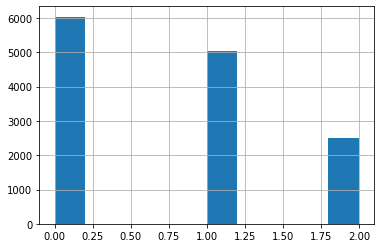



      --------    emotion      --------


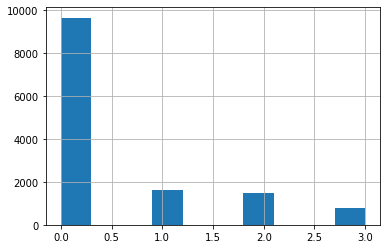



      --------    bodypose      --------


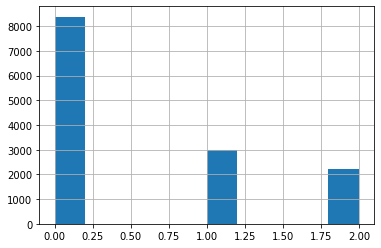

In [0]:
col_list=df.columns.to_list()
for col in col_list[:8]:
  print("\n\n      --------   ",col,"     --------")
  df[col].hist()
  plt.show()

In [0]:
def age_cat_fn(age):
  
  age=str(age)
  if (age=="15-25"):
    return 0
  elif(age=="25-35"):
    return 1
  elif (age=="35-45"):
    return 2
  elif (age=="45-55"):
    return 3
  elif (age=="55+"):
    return 4

def gender_cat_fn(gender):
  if (gender=="male"):
    return 0
  else:
    return 1    

def imagequality_cat_fn(quality):
  if str(quality)=='Average':
    return 0
  elif str(quality)=='Good' :
    return 1 
  elif str(quality)=='Bad' :
    return 2   

def weight_cat_fn(weight):
  if str(weight)=='normal-healthy':
    return 0
  elif str(weight)=='slightly-overweight' :
    return 1
  elif str(weight)=='over-weight' :
    return 2   
  elif str(weight)=='underweight' :
    return 3

def bag_cat_fn(bag):
  if str(bag)=='None':
    return 0
  elif str(bag)=='Daily/Office/Work Bag' :
    return 1
  elif str(bag)=='Grocery/Home/Plastic Bag' :
    return 2   

def footwear_cat_fn(footwear):
  if str(footwear)=='Normal':
    return 0
  elif str(footwear)=='CantSee' :
    return 1
  elif str(footwear)=='Fancy' :
    return 2    

def emotion_cat_fn(emotion):
  if str(emotion)=='Neutral':
    return 0
  elif str(emotion)=='Happy' :
    return 1
  elif str(emotion)=='Angry/Serious' :
    return 2  
  elif str(emotion)=='Sad' :
    return 3  

def pose_cat_fn(pose):
  if str(pose)=='Front-Frontish':
    return 0
  elif str(pose)=='Side' :
    return 1
  elif str(pose)=='Back' :
    return 2              

In [0]:
df['age']=df['age'].map(age_cat_fn)

df['gender']=df['gender'].map(gender_cat_fn)

df['imagequality']=df.imagequality.map(imagequality_cat_fn)

df['weight']=df['weight'].map(weight_cat_fn)

df['carryingbag']=df['carryingbag'].map(bag_cat_fn)

df['footwear']=df['footwear'].map(footwear_cat_fn)

df['emotion']=df['emotion'].map(emotion_cat_fn)

df['bodypose']=df['bodypose'].map(pose_cat_fn)



In [0]:
def pad_img(img):
  pad_size1=img.shape[0]//8
  pad_size2=img.shape[1]//8
  img=np.pad(img, [ (pad_size1, pad_size1), (pad_size2, pad_size2), (0, 0)], mode='reflect')  
  return img 


def random_pad_crop_img(img):
  crop_size1=img.shape[0]
  crop_size2=img.shape[1]
  
  img=pad_img(img)
  pad1=img.shape[0]-crop_size1
  pad2=img.shape[1]-crop_size2
  #print(crop_size1,crop_size2,pad1,pad2)
  x1=np.random.randint(pad1)
  x2=x1+crop_size1
  y1=np.random.randint(pad2)
  y2=y1+crop_size2
  img=img[x1:x2,y1:y2,:]
  return img

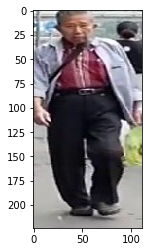

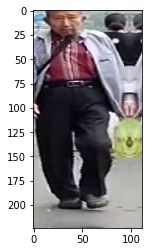

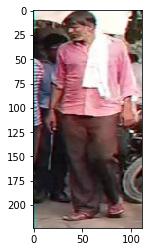

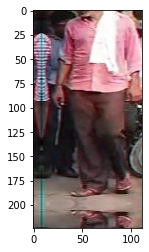

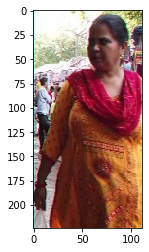

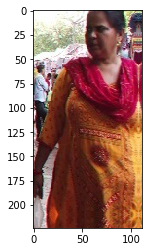

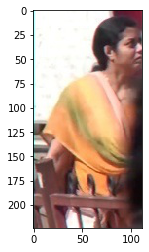

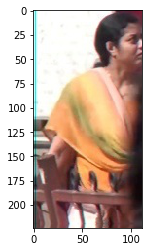

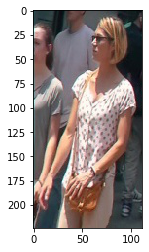

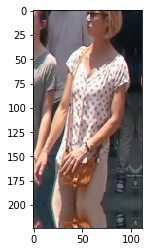

In [0]:

for i in range(5):
  img=plt.imread('./resized/'+image_list2[i])
  plt.imshow(img)
  plt.show()
  img1=random_pad_crop_img(img)
  print("\n\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

In [0]:
def cutout(img,prob=100):
  if np.random.randint(0,100)<prob:
    s1=img.shape[0]
    s2=img.shape[1]
    x1=np.random.randint(s1)
    x2=x1+np.random.randint(s2//4,s1//2)
    
    x3=np.random.randint(s2)
    x4=x3+np.random.randint(s2//4,s1//2)
    im_mean=np.mean(img,axis=(0,1))
    if x2>s1-1:
      x2=s1-1
    if x4>s2-1:
      x4=s2-1  
    img[x1:x2,x3:x4,:]=images_mean

  return img

In [0]:
def cutout2(img,prob=100):
  if np.random.randint(0,100)<prob:
    s1=img.shape[0]
    s2=img.shape[1]
    #print(s1,s2)
    
    x2=s1//4
    x1=np.random.randint(s1//2)-x2
    x3=np.random.randint(s1//2,s1)
    x4=x3+s1//4 #np.random.randint(s2//4,s1//4)

    x5=np.random.randint(s2)
    x6=x5+s1//4 #np.random.randint(s2//4,s1//4)

    x7=np.random.randint(s2)
    x8=x7+s1//4 #np.random.randint(s2//4,s1//4)

    #im_mean=np.mean(img,axis=(0,1))
    if x2>s1-1:
      x2=s1-1
    if x1<0:
      x1=0  
    if x4>s1-1:
      x4=s1-1  
    if x6>s2-1:
      x6=s2-1
    if x8>s2-1:
      x8=s2-1 
    #print(x1,x2,x3,x4,x5,x6,x7,x8) 
    img[x1:x2,x5:x6,:]=images_mean
    img[x3:x4,x7:x8,:] = images_mean

  return img

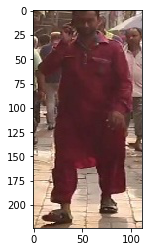

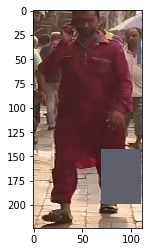

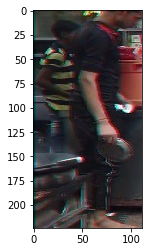

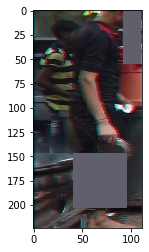

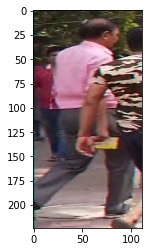

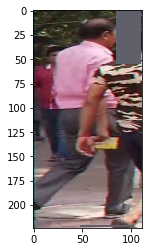

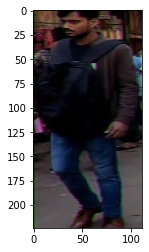

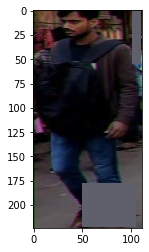

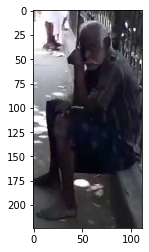

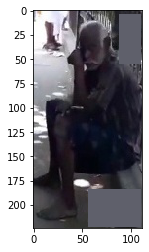

In [0]:
for i in range(70,75):
  img=plt.imread('./resized/'+image_list2[i])
  plt.imshow(img)
  plt.show()
  img1=cutout2(img.copy())
  print("\n\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

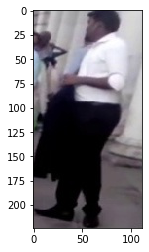

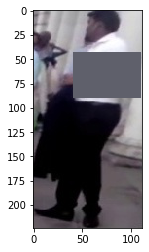

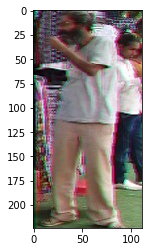

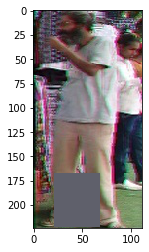

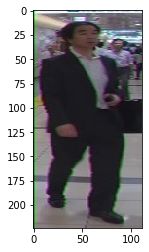

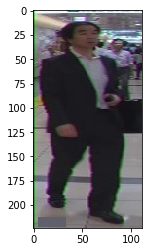

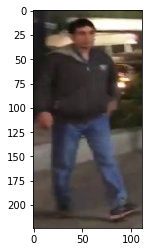

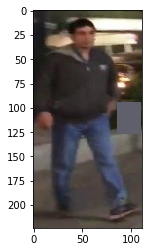

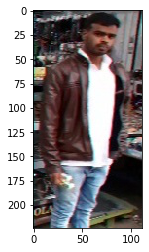

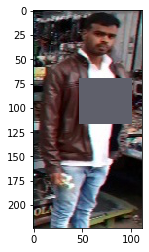

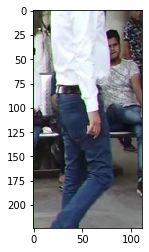

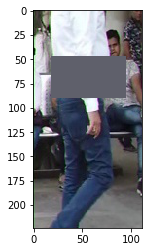

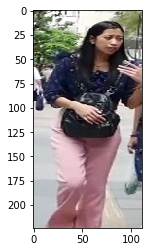

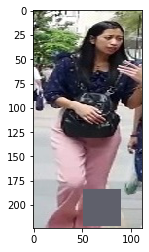

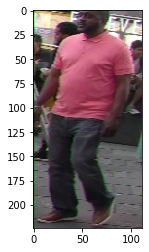

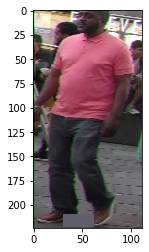

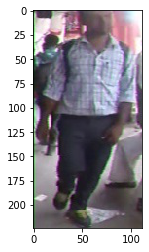

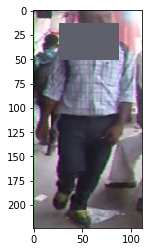

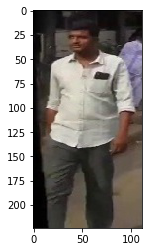

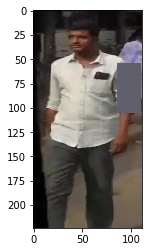

In [0]:
for i in range(50,60):
  img=plt.imread('./resized/'+image_list2[i])
  plt.imshow(img)
  plt.show()
  img1=cutout(img.copy())
  print("\n\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

In [0]:
def h_flip(img,prob=100):
  if np.random.randint(0,100)<prob:
    img=np.fliplr(img)
  return img

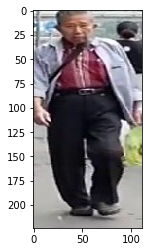

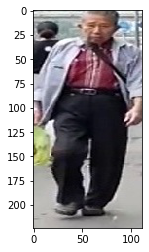

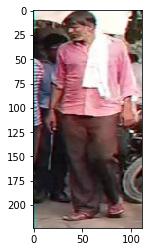

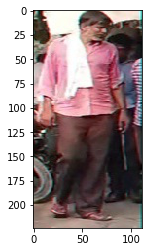

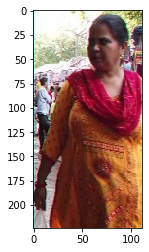

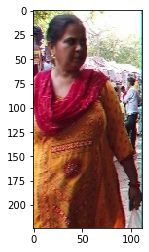

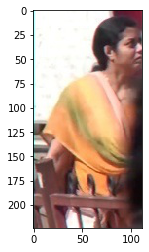

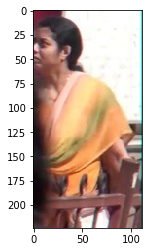

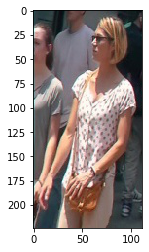

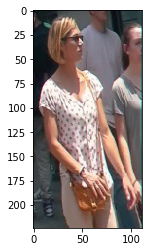

In [0]:
for i in range(5):
  img=plt.imread('./resized/'+image_list2[i])
  plt.imshow(img)
  plt.show()
  img1=h_flip(img)
  print("\n\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

In [0]:
def standardize(img):
  return img.astype('float32')*1.0/255.0

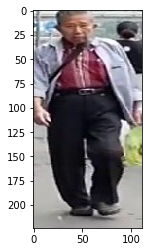

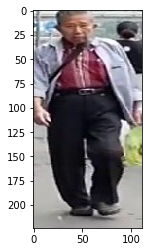

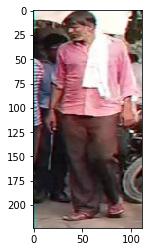

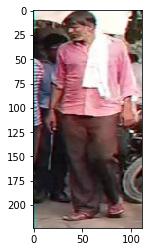

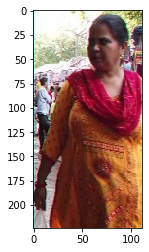

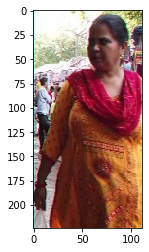

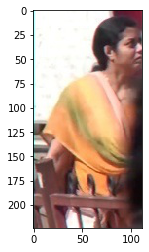

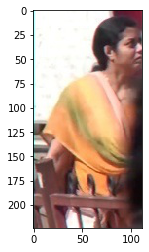

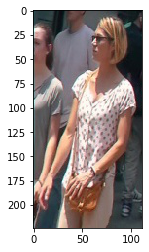

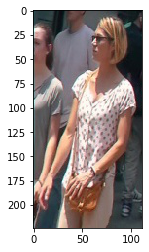

In [0]:
for i in range(5):
  img=plt.imread('./resized/'+image_list2[i])
  plt.imshow(img)
  plt.show()
  img1=standardize(img)
  print("\n\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")

In [0]:
def normalize(img):
  return (img.astype('float32')-images_mean)/images_std

In [0]:
def normalize2(img):
  return (img.astype('float32')-train_mean)/train_std

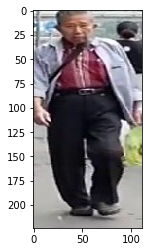

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


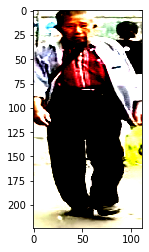

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


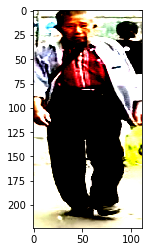

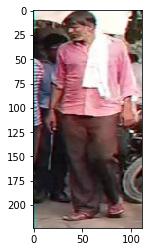

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


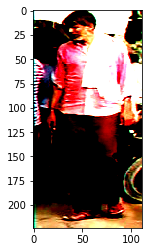

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


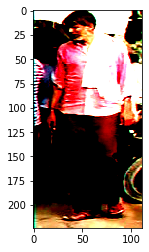

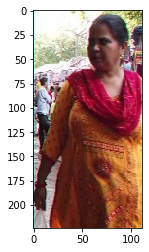

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


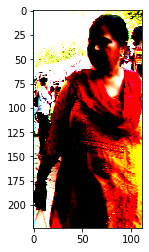

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


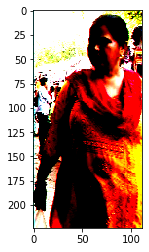

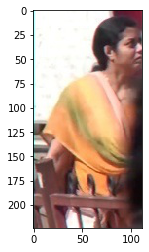

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


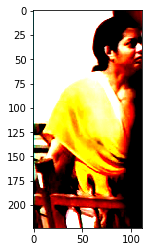

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


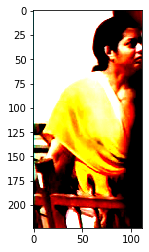

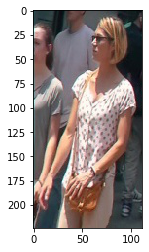

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


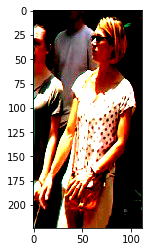

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


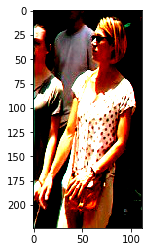

In [0]:
for i in range(5):
  img=plt.imread('./resized/'+image_list2[i])
  plt.imshow(img)
  plt.show()
  img1=normalize(img)
  img2=normalize2(img)
  print("\n\n")
  plt.imshow(img1)
  plt.show()
  print("\n\n")
  
  plt.imshow(img2)
  plt.show()
  print("\n\n")

In [0]:
def img_aug1(img):
  img=normalize(img)
  img=random_pad_crop_img(img)
  img=cutout(img)
  img=h_flip(img,prob=50)
  
  #img=standardize(img)
  return img


def img_aug2(img):
  img=normalize(img)
  img=standardize(img)
  return h_flip(img)  

def img_aug3(img):
  
  img=normalize(img)
  img=random_pad_crop_img(img)
  img=cutout2(img)
  img=h_flip(img,prob=50)
  
  #img=standardize(img)
  
  return img  

def img_aug4(img):
  img=normalize(img)
  #img=standardize(img)
  
  return img        

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.15,shuffle=True,random_state=2019)
train_df.shape, val_df.shape

((11537, 9), (2036, 9))

In [0]:
train_df.head() 

gender  imagequality  age  ...  emotion  bodypose        image_path
5617       1             2    0  ...        0         0  resized/5618.jpg
8015       1             1    0  ...        3         1  resized/8016.jpg
4727       1             0    1  ...        0         2  resized/4728.jpg
6364       1             0    3  ...        0         0  resized/6365.jpg
2036       0             0    1  ...        0         0  resized/2037.jpg

[5 rows x 9 columns]

In [0]:
val_df.head()

gender  imagequality  age  ...  emotion  bodypose         image_path
6901        0             1    2  ...        1         0   resized/6902.jpg
3997        0             0    4  ...        2         1   resized/3998.jpg
11983       0             0    2  ...        0         1  resized/11985.jpg
8397        0             0    2  ...        0         2   resized/8398.jpg
5325        1             0    1  ...        0         2   resized/5326.jpg

[5 rows x 9 columns]

In [0]:
train_df.head() 

gender  imagequality  age  ...  emotion  bodypose        image_path
5617       1             2    0  ...        0         0  resized/5618.jpg
8015       1             1    0  ...        3         1  resized/8016.jpg
4727       1             0    1  ...        0         2  resized/4728.jpg
6364       1             0    3  ...        0         0  resized/6365.jpg
2036       0             0    1  ...        0         0  resized/2037.jpg

[5 rows x 9 columns]

In [0]:
val_df.head()

gender  imagequality  age  ...  emotion  bodypose         image_path
6901        0             1    2  ...        1         0   resized/6902.jpg
3997        0             0    4  ...        2         1   resized/3998.jpg
11983       0             0    2  ...        0         1  resized/11985.jpg
8397        0             0    2  ...        0         2   resized/8398.jpg
5325        1             0    1  ...        0         2   resized/5326.jpg

[5 rows x 9 columns]

In [0]:
train_df.head()

gender  imagequality  age  ...  emotion  bodypose        image_path
5617       1             2    0  ...        0         0  resized/5618.jpg
8015       1             1    0  ...        3         1  resized/8016.jpg
4727       1             0    1  ...        0         2  resized/4728.jpg
6364       1             0    3  ...        0         0  resized/6365.jpg
2036       0             0    1  ...        0         0  resized/2037.jpg

[5 rows x 9 columns]

In [0]:
val_df.head()

gender  imagequality  age  ...  emotion  bodypose         image_path
6901        0             1    2  ...        1         0   resized/6902.jpg
3997        0             0    4  ...        2         1   resized/3998.jpg
11983       0             0    2  ...        0         1  resized/11985.jpg
8397        0             0    2  ...        0         2   resized/8398.jpg
5325        1             0    1  ...        0         2   resized/5326.jpg

[5 rows x 9 columns]



    ----  training samples distribution  ------




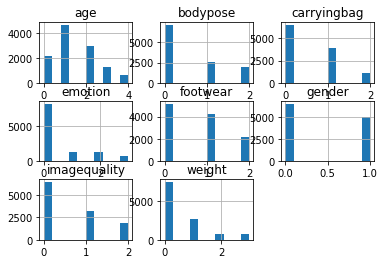



    ----  validation samples distribution  ------




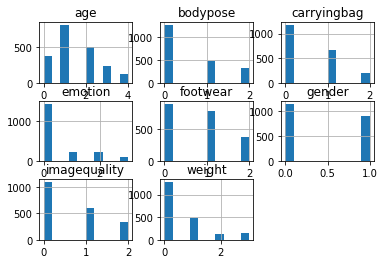

In [0]:

print('\n\n    ----  training samples distribution  ------\n\n')
train_df[col_list].hist()

plt.show()

print('\n\n    ----  validation samples distribution  ------\n\n')
val_df[col_list].hist()

plt.show()

In [0]:
'''
train_data=[]
train_list=train_df.image_path.to_list()
for i in range(len(train_list)):
  img=cv2.imread('./'+train_list[i])
  
  train_data.append(img)
train_data=np.array(train_data) 
print(train_data.shape)
train_mean=np.mean(train_data,axis=(0,1,2))
train_std=np.std(train_data,axis=(0,1,2))
print(train_mean,train_std)
'''

(11537, 224, 112, 3)
[ 95.71529081  96.68349732 107.46963835] [64.89201484 65.99917021 67.67713818]


In [0]:
train_mean=[ 95.71529081 , 96.68349732, 107.46963835]
train_std = [64.89201484 , 65.99917021 , 67.67713818]


[95.55573314, 96.53671704, 107.34702047] [64.81507208, 65.94565732, 67.6457798]


In [0]:
age_df=train_df.loc[(train_df['age']>=3) & (train_df['bodypose']>=1) & 
                    (train_df['emotion']>=1) &
                    (train_df['weight']>=2) ]


In [0]:
age_df.age.value_counts()

3    24
4    12
Name: age, dtype: int64

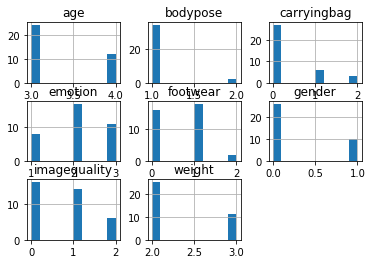

In [0]:
age_df.hist()
plt.show()

In [0]:
mod_df=train_df.append(age_df)
for i in range(100):
  mod_df=mod_df.append(age_df)

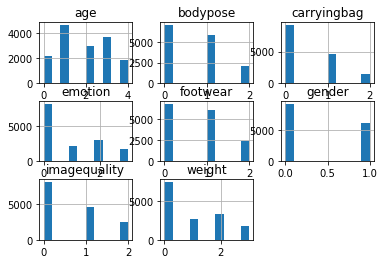

In [0]:
mod_df.hist()
plt.show()

In [0]:
gender_df=mod_df.loc[(mod_df['gender']>=1) & (mod_df['bodypose']>=2) & 
                    (mod_df['emotion']>=1) & (mod_df['age'] !=1) &
                    (mod_df['weight']>=1) ]


1    7
Name: gender, dtype: int64


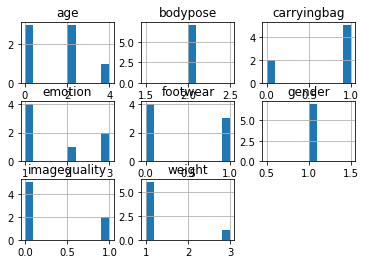

In [0]:
print(gender_df.gender.value_counts())

gender_df.hist()
plt.show()

In [0]:
mod_df1=mod_df.append(gender_df)
for i in range(200):
  mod_df1=mod_df1.append(gender_df)

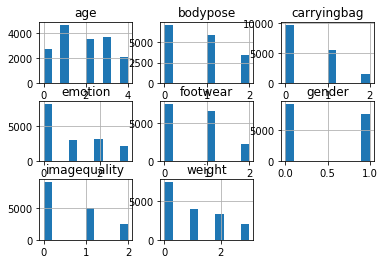

In [0]:
mod_df1.hist()
plt.show()

In [0]:
emotion_df=mod_df.loc[ (mod_df['bodypose']>=2) & 
                    (mod_df['emotion']>=1) & (mod_df['age'] !=1) &
                    (mod_df['weight']>=1) ]


2    109
3    107
1      8
Name: emotion, dtype: int64


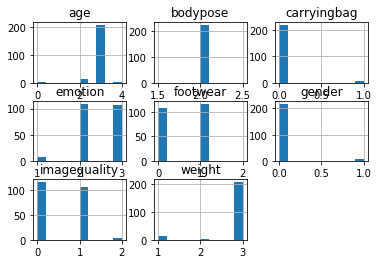

In [0]:
print(emotion_df.emotion.value_counts())

emotion_df.hist()
plt.show()

In [0]:
mod_df2=mod_df1.append(emotion_df)

for i in range(10):
  mod_df2=mod_df2.append(emotion_df)

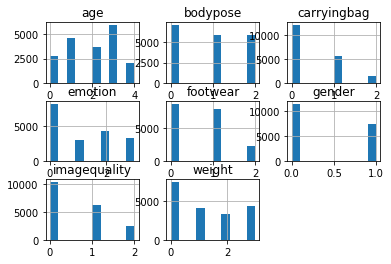

In [0]:
mod_df2.hist()
plt.show()

In [0]:
bag_df=mod_df2.loc[ (mod_df2['carryingbag']>=1) & 
                    (mod_df2['emotion']>=1) & (mod_df2['gender'] !=0) & (mod_df2.age !=3) &
                    (mod_df2['weight']>=1) ]

1    1384
2     150
Name: carryingbag, dtype: int64


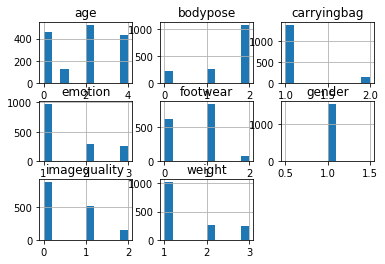

In [0]:
print(bag_df.carryingbag.value_counts())

bag_df.hist()
plt.show()

In [0]:
mod_df3=mod_df2.append(bag_df)

for i in range(2):
  mod_df3=mod_df3.append(bag_df)

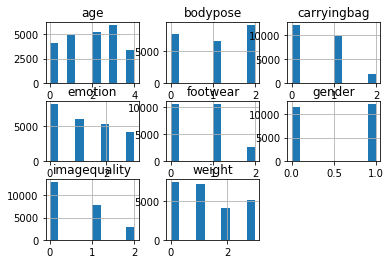

In [0]:
mod_df3.hist()
plt.show()

In [0]:
# create train and validation data generators
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        preprocessing_function=img_aug3
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=img_aug4
    )

train_gen = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224, 112), interpolation='bicubic',
        batch_size=32,
        class_mode='multi_output')

val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224, 112),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 16580 validated image filenames.
Found 2036 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


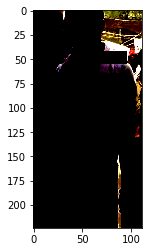

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


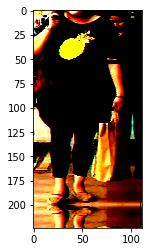

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


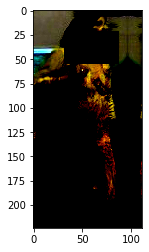

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


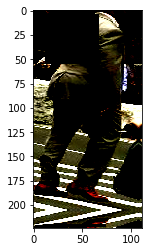

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


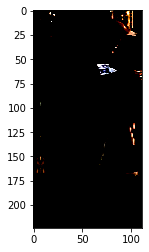

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


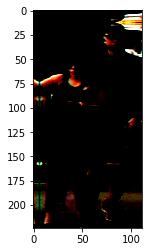

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


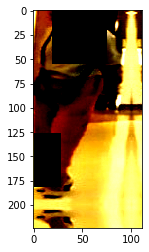

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


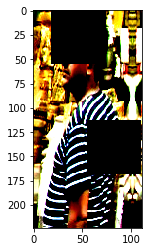

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


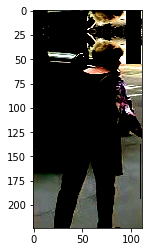

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


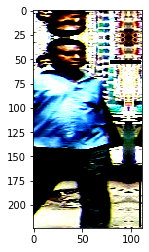

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


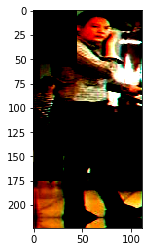

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


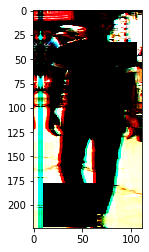

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


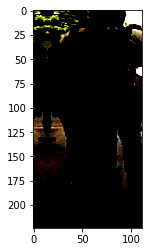

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


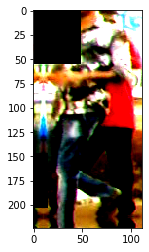

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


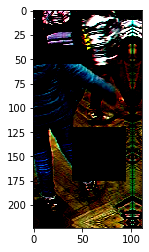

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


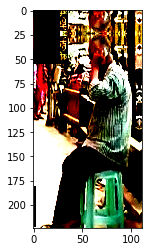

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


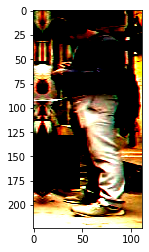

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


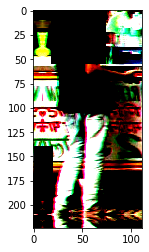

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


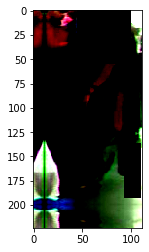

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


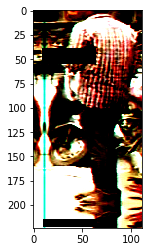

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


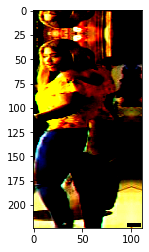

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


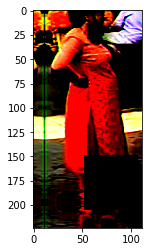

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


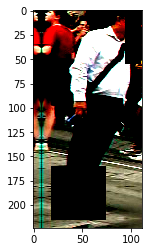

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


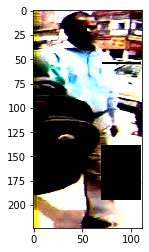

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


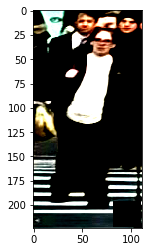

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


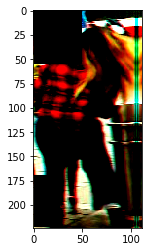

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


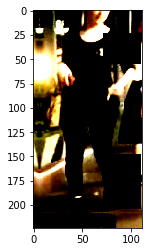

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


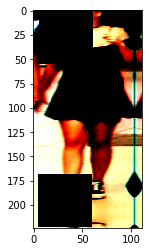

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


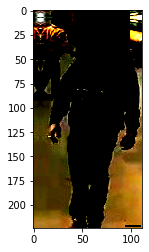

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


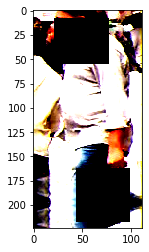

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


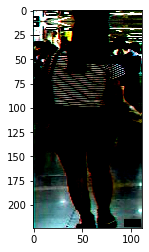

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


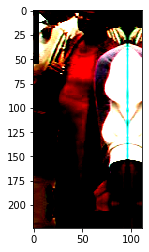

In [0]:
images,labels=train_gen.next()
for img in images:
  
  plt.imshow(img.astype('float32'))
  plt.show()
  print('\n\n')

In [0]:
# get number of output units from data
num_units={}
for col in df.columns:
  if col!='image_path':
    num_units[col]=len(df[col].unique())


print(num_units)

{'gender': 2, 'imagequality': 3, 'age': 5, 'weight': 4, 'carryingbag': 3, 'footwear': 3, 'emotion': 4, 'bodypose': 3}


In [0]:
import tensorflow as tf
wt_init = tf.keras.initializers.TruncatedNormal(mean=0.0,stddev=0.05,
                                                          seed=2019)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
import keras
WEIGHT_DECAY=1.25e-4
reg=keras.regularizers.l2(WEIGHT_DECAY)
def conv(inp,f=32,k1=3,k2=3,s1=1,s2=1,padng='same'):
  conv_layer=Conv2D(f,(k1,k2),strides=(s1,s2),use_bias=False,padding=padng,kernel_initializer=wt_init, kernel_regularizer=reg)(inp)
  conv_layer=BatchNormalization(momentum=0.9, epsilon=1e-5)(conv_layer)
  conv_layer=Activation('relu')(conv_layer)
  conv_layer=Dropout(0.05)(conv_layer)
  return conv_layer

def resBlk(inp,f=32,k=3,residual=True) :
  res1=conv(inp,f)
  res2=conv(res1,f)  

  res2=MaxPooling2D(pool_size=(2,2))(res2)

  if residual:
    res3=conv(res2,f)
    res4=conv(res3,f)
    
    return Add()([res2,res4])
  else:
    return res2 

In [0]:
def build_head(name, in_layer,add_dense=True):

  if name=='gender':
    activatione='softmax'
  else:
    activatione='softmax'  
  if add_dense:
    last_layer=  Dense(64, kernel_initializer=wt_init, activation='relu',use_bias=False,kernel_regularizer=reg)(in_layer)
    last_layer= BatchNormalization(momentum=0.9, epsilon=1e-5)(last_layer)
    #last_layer=  Dense(64, kernel_initializer=wt_init,use_bias=False,kernel_regularizer=reg)(last_layer)
    
  else:
    last_layer=in_layer 

  last_layer =Dense(num_units[name], use_bias=False,kernel_initializer=wt_init)(last_layer)   
  #last_layer=Lambda(lambda x: x*0.125)(last_layer)
  out=Activation('softmax',name=f"{name}_output") (last_layer)
  return out 

  '''  
  return Dense(
        num_units[name], activation=activatione, name=f"{name}_output",use_bias=False,kernel_initializer=wt_init
    )(last_layer)
  '''  

In [0]:
def build_main_branch(inp,f):
  layer1=conv(inp,f,k1=7,k2=3,s1=1,s2=1,padng='valid')
  res1=resBlk(layer1,f*2,3,True)
  
  res2=resBlk(res1,f*4,3,True)
  
  res3=resBlk(res2,f*8,3,True)
  res4=resBlk(res3,f*8,3,True)
  res5=resBlk(res4,f*8,3,True)

  last_block=conv(res5,f*8,k1=5,k2=3,s1=1,s2=1,padng='same')
  last_block=conv(last_block,f*8,k1=3,k2=3,s1=1,s2=1,padng='same')
  last_block=conv(last_block,f*8,k1=3,k2=3,s1=1,s2=1,padng='same')
  last_block=Conv2D(f*4,1,use_bias=False,kernel_initializer=wt_init, kernel_regularizer=reg,activation='relu')(last_block)
  last_block= BatchNormalization(momentum=0.9, epsilon=1e-5)(last_block)
  layer2=GlobalAveragePooling2D()(last_block)
  

  #layer3=Dense(512, kernel_initializer=wt_init, activation='relu',use_bias=False,kernel_regularizer=reg)(layer2)
  #layer3 = BatchNormalization(momentum=0.9, epsilon=1e-5)(layer3)
  
  #out=Activation('softmax')(layer3)
  return layer2

In [0]:
def crop_top1(img):
  #print(type(img))
  #print('shape',shp)
  h1=img.shape[1]//2
  
  return img[:,0:h1,:,:]

In [0]:
def crop_botm1(img):
  #print(type(img))
  #print('shape',shp)
  h1=img.shape[1]//2
  
  return img[:,h1:,:,:]

In [0]:
def build_age_branch(inp,f):
  #inp2=Lambda(lambda x:crop_top)(inp)
  layer1=conv(inp,f,k1=3,k2=3,s1=1,s2=1,padng='same')
  res1=resBlk(layer1,f*2,3,True)
  
  res2=resBlk(res1,f*4,3,True)
  
  res3=resBlk(res2,f*4,3,True)

  res4=resBlk(res3,f*8,3,True)

  last_block=conv(res4,f*8,k1=3,k2=3,s1=1,s2=1,padng='same')
  last_block1=conv(last_block,f*8,k1=3,k2=3,s1=1,s2=1,padng='valid')
  last_block2=conv(last_block1,f*8,k1=3,k2=3,s1=1,s2=1,padng='same')
  last_block3=Conv2D(f*4,1,use_bias=False,kernel_initializer=wt_init, kernel_regularizer=reg,activation='relu')(last_block2)
  last_block3= BatchNormalization(momentum=0.9, epsilon=1e-5)(last_block3)

  


  layer2=GlobalAveragePooling2D()(last_block3)
  
  return layer2

In [0]:
def build_foot_branch(inp,f):
  #inp2=Lambda(lambda x:crop_top)(inp)
  
  layer1=conv(inp,f,k1=3,k2=3,s1=1,s2=1,padng='same')
  res1=resBlk(layer1,f*2,3,True)
  
  res2=resBlk(res1,f*4,3,True)
  
  res3=resBlk(res2,f*8,3,True)

  res4=resBlk(res3,f*8,3,True)

  last_block=conv(res4,f*8,k1=3,k2=3,s1=1,s2=1,padng='same')
  last_block1=conv(last_block,f*8,k1=3,k2=3,s1=1,s2=1,padng='same')
  last_block2=conv(last_block1,f*8,k1=3,k2=3,s1=1,s2=1,padng='valid')
  last_block3=Conv2D(f*4,1,use_bias=False,padding='valid',kernel_initializer=wt_init, kernel_regularizer=reg,activation='relu')(last_block2)
  last_block3= BatchNormalization(momentum=0.9, epsilon=1e-5)(last_block3)
  layer2=GlobalAveragePooling2D()(last_block3)

  #layer3=Dense(512, kernel_initializer='he_normal', activation='relu',use_bias=False,kernel_regularizer=reg)(layer2)
  
  #out=Activation('softmax')(layer3)
  return layer2

In [0]:
def build_model():
  f=32
  inp=Input(shape=(224,112,3))
  #inp1=Lambda(lambda x:standardize(x))(inp)
  inp2=Lambda(lambda x:crop_top1(x))(inp)
  inp3=Lambda(lambda x:crop_botm1(x))(inp)
  main_branch=build_main_branch(inp,f)
  age_branch=build_age_branch(inp2,f)
  foot_branch=build_foot_branch(inp3,f)

  gender = build_head("gender", main_branch)
  image_quality = build_head("imagequality", main_branch)
  age=Add()([age_branch,main_branch])
  age = build_head("age", age)
  weight = build_head("weight", main_branch)
  bag = build_head("carryingbag", main_branch)
  footwear = Add()([foot_branch,main_branch])
  footwear = build_head("footwear", footwear)
  emotion=Add()([age_branch,main_branch])
  emotion = build_head("emotion", emotion)
  pose = build_head("bodypose", main_branch)
  model=Model(inputs=[inp],outputs=[gender,image_quality,age,weight,bag,footwear,emotion,pose])
  #model=Model(inputs=[inp],outputs=[gender])
  model.summary()
  return model 

In [0]:
model=build_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 112, 3)  0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 218, 110, 32) 2016        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_101 (BatchN (None, 218, 110, 32) 128         conv2d_93[0][0]                  
__________________________________________________________________________________________________
activation_89 (Activation)      (None, 218, 110, 32) 0           batch_normalization_101[0][0]    
____________________________________________________________________________________________

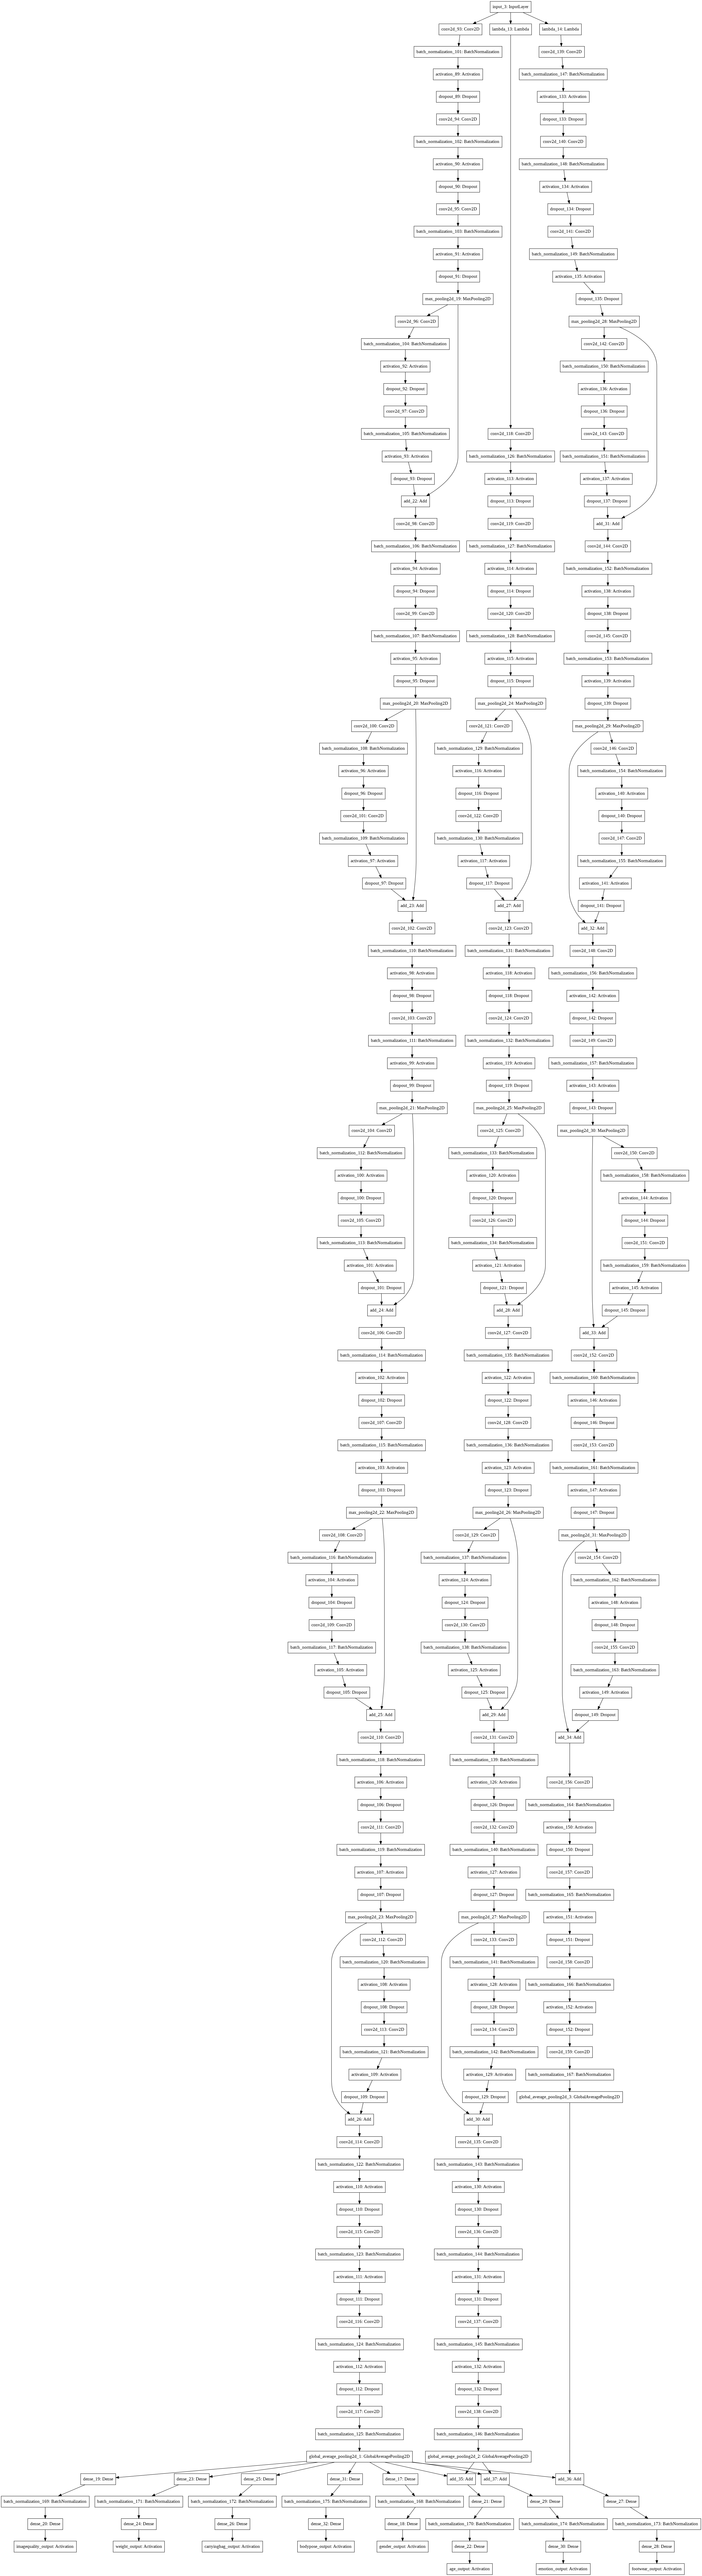

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image, display
display(Image('model.png'))

In [0]:
losses = {
 	"gender_output": "categorical_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy",

 }

loss_weights = {"gender_output": 0.5, 
                 "imagequality_output": 1.5, 
                 "age_output": 1.0,
                 "weight_output": 1.0,
                  "carryingbag_output": 1.0,
                  "bodypose_output": 1.0,
                  "footwear_output": 1.0,
                  "emotion_output": 1.0,
                 
                 }
opt = SGD(lr=0.0001, momentum=0.9,nesterov=True)
'''
model.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)
'''
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path="/content/gdrive/My Drive/EIP4/session5/best_model-{epoch:03d}.h5"


chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_gender_output_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [0]:
EPOCHS=50

def scheduler(epoch):
  #lr=np.interp([epoch],[0, EPOCHS//5,(EPOCHS//5)+1,EPOCHS], [0.001, 0.001,0.0009, 0.0008])[0]
  lr=np.interp([epoch],[0, EPOCHS//10,(EPOCHS//5)+1,EPOCHS//2,EPOCHS], [0.0001, 0.2,0.1,0.002, 0.001])[0]
  print('epoch ', epoch+1, ': setting learning rate to ',lr)
  return lr

'''
  if epoch < 5:
    return 0.02
  elif 5 < epoch < 12: 
    return 0.015 
  elif 12 < epoch < 20: 
    return 0.010
  elif 20 < epoch < 25: 
    return 0.007      
  else:
    return 0.003

'''    

lr_callback = keras.callbacks.LearningRateScheduler(scheduler)


In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=val_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,callbacks=[lr_callback,chkpoint_model],
    verbose=2
)

Epoch 1/50
epoch  1 : setting learning rate to  0.0001


 - 364s - loss: 14.0194 - gender_output_loss: 0.6269 - imagequality_output_loss: 1.0514 - age_output_loss: 1.4626 - weight_output_loss: 1.2962 - carryingbag_output_loss: 1.0099 - footwear_output_loss: 1.0093 - emotion_output_loss: 1.2738 - bodypose_output_loss: 1.0630 - gender_output_acc: 0.6302 - imagequality_output_acc: 0.4653 - age_output_acc: 0.3848 - weight_output_acc: 0.3903 - carryingbag_output_acc: 0.5211 - footwear_output_acc: 0.5245 - emotion_output_acc: 0.4092 - bodypose_output_acc: 0.4143 - val_loss: 15.5704 - val_gender_output_loss: 0.8270 - val_imagequality_output_loss: 1.2721 - val_age_output_loss: 1.7270 - val_weight_output_loss: 1.4366 - val_carryingbag_output_loss: 1.2688 - val_footwear_output_loss: 1.2520 - val_emotion_output_loss: 1.4718 - val_bodypose_output_loss: 1.0894 - val_gender_output_acc: 0.4990 - val_imagequality_output_acc: 0.3021 - val_age_output_acc: 0.2068 - val_weight_output_acc: 0.2863 - val_car

In [0]:
!ls '/content/gdrive/My Drive/EIP4/session5/best_model-050.h5'

'/content/gdrive/My Drive/EIP4/session5/best_model-050.h5'


In [0]:
!cp '/content/gdrive/My Drive/EIP4/session5/best_model-050.h5' './'

In [0]:
from keras.models import load_model
file_path='./best_model-050.h5'
cust = {'crop_top1': crop_top1, 'crop_botm1': crop_botm1}
model=load_model('/content/gdrive/My Drive/EIP4/session5/best_model-050.h5',cust)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
#gender,image_quality,age,weight,bag,footwear,emotion,pose

loss_weights = {"gender_output": 1.0, 
                 "imagequality_output": 4.0, 
                 "age_output": 6.0,
                 "weight_output": 1.5,
                  "carryingbag_output": 1.5,
                  "footwear_output": 2.0,
                  "emotion_output": 3.0,
                   "bodypose_output": 1.0
                 
                 }
opt = SGD(lr=0.001, momentum=0.9,nesterov=True,decay=1e-5)
'''
model.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)
'''
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    loss_weights=loss_weights,
    metrics=['accuracy']
)

In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path="/content/gdrive/My Drive/EIP4/session5/best_model-{epoch:03d}.h5"


chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_gender_output_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [0]:
EPOCHS=65
def scheduler2(epoch):
  lr=np.interp([epoch],[50,60,65], [0.001, 0.001,0.00095])[0]
  print('epoch ', epoch+1, ': setting learning rate to ',lr)
  return lr


lr_callback2 = keras.callbacks.LearningRateScheduler(scheduler2)

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=img_aug3)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
        dataframe=mod_df3,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224, 112), interpolation='bicubic',
        batch_size=32,
        class_mode='multi_output')

val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224, 112),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 23646 validated image filenames.
Found 2036 validated image filenames.


In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=val_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=EPOCHS,callbacks=[lr_callback2,chkpoint_model],initial_epoch=50,
    verbose=2
)

Epoch 51/65
epoch  51 : setting learning rate to  0.001


Epoch 51/65 - 373s - loss: 10.2179 - gender_output_loss: 0.1754 - imagequality_output_loss: 0.4839 - age_output_loss: 0.6690 - weight_output_loss: 0.4558 - carryingbag_output_loss: 0.3908 - footwear_output_loss: 0.3889 - emotion_output_loss: 0.4454 - bodypose_output_loss: 0.2333 - gender_output_acc: 0.9197 - imagequality_output_acc: 0.7746 - age_output_acc: 0.7099 - weight_output_acc: 0.8212 - carryingbag_output_acc: 0.8332 - footwear_output_acc: 0.8326 - emotion_output_acc: 0.8457 - bodypose_output_acc: 0.9093 - val_loss: 20.7466 - val_gender_output_loss: 0.4480 - val_imagequality_output_loss: 0.9855 - val_age_output_loss: 1.3674 - val_weight_output_loss: 1.0043 - val_carryingbag_output_loss: 0.8376 - val_footwear_output_loss: 0.7873 - val_emotion_output_loss: 0.9183 - val_bodypose_output_loss: 0.5846 - val_gender_output_acc: 0.7839 - val_imagequality_output_acc: 0.5314 - val_age_output_acc: 0.3993 - val_weight_output_acc: 0.59

In [0]:
from keras.models import load_model

cust = {'crop_top1': crop_top1, 'crop_botm1': crop_botm1}
model=load_model('/content/gdrive/My Drive/EIP4/session5/best_model-061.h5',cust)

In [0]:
#gender,image_quality,age,weight,bag,footwear,emotion,pose

loss_weights = {"gender_output": 0.2, 
                 "imagequality_output": 0.5, 
                 "age_output": 3.0,
                 "weight_output": 0.5,
                  "carryingbag_output": 0.5,
                  "footwear_output": 1.0,
                  "emotion_output": 1.0,
                   "bodypose_output": 0.2
                 
                 }
opt = SGD(lr=0.0005, momentum=0.9,nesterov=True,decay=1e-5)
'''
model.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)
'''
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    loss_weights=loss_weights,
    metrics=['accuracy']
)

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=val_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=265,callbacks=[chkpoint_model],initial_epoch=65,
    verbose=2
)

Epoch 66/265
 - 343s - loss: 12.5402 - gender_output_loss: 0.1744 - imagequality_output_loss: 0.4472 - age_output_loss: 0.5788 - weight_output_loss: 0.4495 - carryingbag_output_loss: 0.3819 - footwear_output_loss: 0.3753 - emotion_output_loss: 0.4160 - bodypose_output_loss: 0.2332 - gender_output_acc: 0.9218 - imagequality_output_acc: 0.7888 - age_output_acc: 0.7507 - weight_output_acc: 0.8236 - carryingbag_output_acc: 0.8383 - footwear_output_acc: 0.8366 - emotion_output_acc: 0.8553 - bodypose_output_acc: 0.9070 - val_loss: 28.5294 - val_gender_output_loss: 0.4522 - val_imagequality_output_loss: 1.0100 - val_age_output_loss: 1.4057 - val_weight_output_loss: 0.9725 - val_carryingbag_output_loss: 0.8426 - val_footwear_output_loss: 0.7837 - val_emotion_output_loss: 0.9254 - val_bodypose_output_loss: 0.5853 - val_gender_output_acc: 0.7903 - val_imagequality_output_acc: 0.5236 - val_age_output_acc: 0.4013 - val_weight_output_acc: 0.6306 - val_carryingbag_output_acc: 0.6311 - val_footwear_o

In [0]:
from keras.models import load_model

cust = {'crop_top1': crop_top1, 'crop_botm1': crop_botm1}
model=load_model('/content/gdrive/My Drive/EIP4/session5/best_model-069.h5',cust)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
#gender,image_quality,age,weight,bag,footwear,emotion,pose

loss_weights = {"gender_output": 0.2, 
                 "imagequality_output": 0.5, 
                 "age_output": 3.0,
                 "weight_output": 0.5,
                  "carryingbag_output": 0.5,
                  "footwear_output": 1.0,
                  "emotion_output": 1.0,
                   "bodypose_output": 0.2
                 
                 }
opt = SGD(lr=0.0008, momentum=0.9,nesterov=True,decay=1e-5)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

In [0]:
# create train and validation data generators
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #horizontal_flip=True
        preprocessing_function=img_aug3
        )

val_datagen = ImageDataGenerator(
    #rescale=1./255
    preprocessing_function=img_aug4
    )

train_gen = train_datagen.flow_from_dataframe(
        dataframe=mod_df1,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224, 112), interpolation='bicubic',
        batch_size=32,
        class_mode='multi_output')

val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory='./',
        x_col="image_path",
        y_col=['gender',	'imagequality',	'age'	,'weight'	,'carryingbag',	'footwear',	'emotion'	,'bodypose'],
        target_size=(224, 112),interpolation='bicubic',
        batch_size=64,
        class_mode='multi_output')

Found 16580 validated image filenames.
Found 2036 validated image filenames.


In [0]:
from keras.callbacks import ModelCheckpoint

model_save_path="/content/gdrive/My Drive/EIP4/session5/best_model-{epoch:03d}.h5"


chkpoint_model=ModelCheckpoint(model_save_path, monitor='val_gender_output_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=val_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=100,callbacks=[chkpoint_model],initial_epoch=73,
    verbose=2
)

Epoch 74/100
Epoch 74/100
Epoch 74/100
 - 295s - loss: 5.6248 - gender_output_loss: 0.3778 - imagequality_output_loss: 0.6911 - age_output_loss: 0.9612 - weight_output_loss: 0.7008 - carryingbag_output_loss: 0.6016 - footwear_output_loss: 0.6337 - emotion_output_loss: 0.6552 - bodypose_output_loss: 0.5246 - gender_output_acc: 0.8306 - imagequality_output_acc: 0.6871 - age_output_acc: 0.5931 - weight_output_acc: 0.7339 - carryingbag_output_acc: 0.7430 - footwear_output_acc: 0.7230 - emotion_output_acc: 0.7820 - bodypose_output_acc: 0.7994 - val_loss: 8.3592 - val_gender_output_loss: 0.6106 - val_imagequality_output_loss: 1.3831 - val_age_output_loss: 1.5003 - val_weight_output_loss: 1.0128 - val_carryingbag_output_loss: 0.8786 - val_footwear_output_loss: 0.9038 - val_emotion_output_loss: 0.9334 - val_bodypose_output_loss: 0.6581 - val_gender_output_acc: 0.6911 - val_imagequality_output_acc: 0.3718 - val_age_output_acc: 0.3649 - val_weight_output_acc: 0.6115 - val_carryingbag_output_acc:

In [0]:
opt = SGD(lr=0.0005, momentum=0.9,nesterov=True,decay=1e-5)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy', 
    
    metrics=['accuracy']
)

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=val_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=150,callbacks=[chkpoint_model],initial_epoch=100,
    verbose=2
)

Epoch 74/100
Epoch 74/100
Epoch 74/100
 - 295s - loss: 5.6248 - gender_output_loss: 0.3778 - imagequality_output_loss: 0.6911 - age_output_loss: 0.9612 - weight_output_loss: 0.7008 - carryingbag_output_loss: 0.6016 - footwear_output_loss: 0.6337 - emotion_output_loss: 0.6552 - bodypose_output_loss: 0.5246 - gender_output_acc: 0.8306 - imagequality_output_acc: 0.6871 - age_output_acc: 0.5931 - weight_output_acc: 0.7339 - carryingbag_output_acc: 0.7430 - footwear_output_acc: 0.7230 - emotion_output_acc: 0.7820 - bodypose_output_acc: 0.7994 - val_loss: 8.3592 - val_gender_output_loss: 0.6106 - val_imagequality_output_loss: 1.3831 - val_age_output_loss: 1.5003 - val_weight_output_loss: 1.0128 - val_carryingbag_output_loss: 0.8786 - val_footwear_output_loss: 0.9038 - val_emotion_output_loss: 0.9334 - val_bodypose_output_loss: 0.6581 - val_gender_output_acc: 0.6911 - val_imagequality_output_acc: 0.3718 - val_age_output_acc: 0.3649 - val_weight_output_acc: 0.6115 - val_carryingbag_output_acc:

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=10,callbacks=[chkpoint_model,lr_callback],
    verbose=1
)

In [0]:
model